# Visualise the STBM scenarios

In [1]:
import os

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from nw2vec import viz

Using TensorFlow backend.


In [ ]:
STBM_PATH = os.path.join(settings.BEHAVIOUR_PATH, 'stbm')

In [2]:
S1 = np.load(STBM_PATH + '/scenario-1.npz')
S2 = np.load(STBM_PATH + '/scenario-2.npz')
S3 = np.load(STBM_PATH + '/scenario-3.npz')

In [3]:
def plot_scenario(npz, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    else:
        fig = ax.figure
    
    # Load the data and recover shape variables
    Y, A, Z, W = npz['Y'], npz['A'], npz['Z'], npz['W']
    n_nodes, n_clusters = Y.shape
    n_documents, n_slots = W.shape[-2:]
    n_topics = int(Z[np.isfinite(Z)].max()) + 1
    vocabulary_size = int(W[np.isfinite(W)].max()) + 1

    # Create the graph structure
    g = nx.from_numpy_array(A, create_using=nx.DiGraph())

    # Recover the maximum topic of each edge...
    edges = np.array(g.edges)
    edges_Z = Z[list(edges.T)].astype(np.int)
    edge_doc_maxtopic = np.zeros((len(edges), n_documents), dtype=np.int)

    # ... first get the maximum topic for each document of each edge
    for i, edge in enumerate(edges_Z):
        for j, doc in enumerate(edge):
            edge_doc_maxtopic[i, j] = np.argmax(np.bincount(doc))

    # ... then get the maximum topic for each edge based on document maxtopics
    edge_maxtopic = np.zeros(len(edges), dtype=np.int)
    for i, edge in enumerate(edge_doc_maxtopic):
        edge_maxtopic[i] = np.argmax(np.bincount(edge))

    # Prepare colors and layout
    clusters_palette = np.array(sb.color_palette('dark', n_colors=n_clusters))
    topics_palette = np.array(sb.color_palette('Set2', n_colors=n_topics))
    #topics_palette = np.concatenate([np.array(sb.color_palette(n_colors=n_topics)), .3 * np.ones((n_topics, 1))], axis=1)
    layout = nx.layout.spring_layout(g)
    titles, xys = zip(*sorted(layout.items()))
    xys = np.array(xys)

    # Plot
    nx.draw_networkx_edges(g, layout, edge_color=topics_palette[edge_maxtopic], ax=ax)
    ax.scatter(xys[:, 0], xys[:, 1], s=50, c=clusters_palette[np.where(Y)[1]], zorder=10)

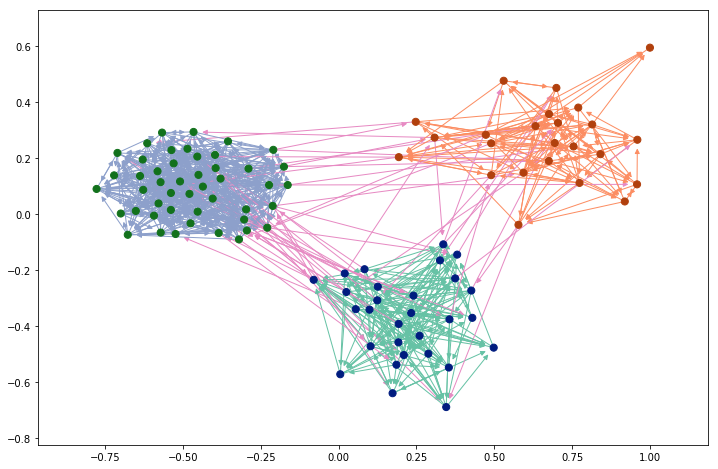

In [4]:
plot_scenario(S1)

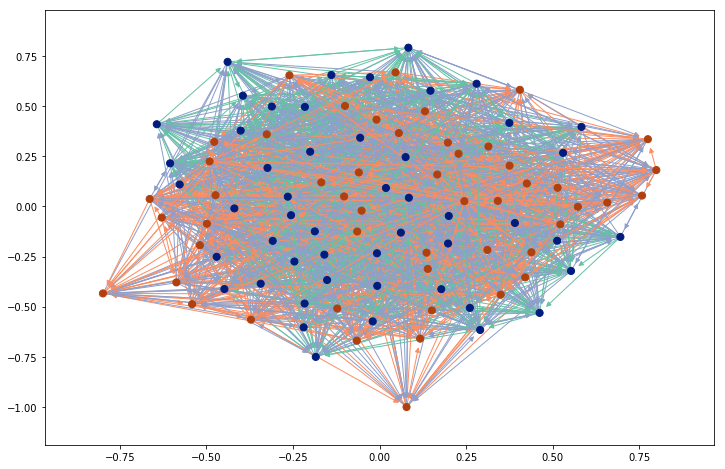

In [5]:
plot_scenario(S2)

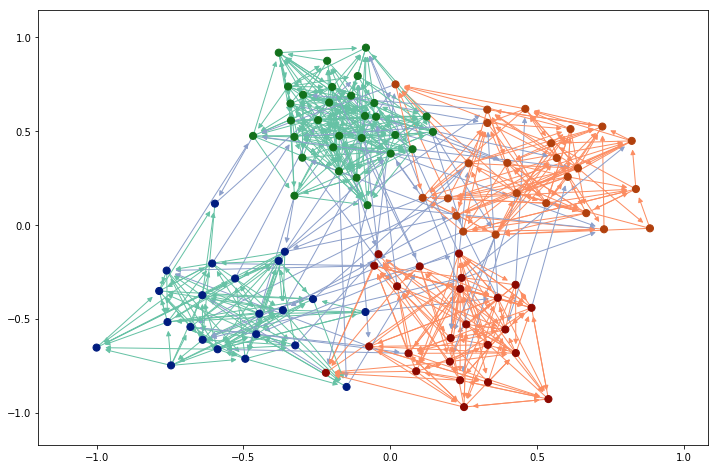

In [6]:
plot_scenario(S3)

# Convert the scenarios to nw2vec format and re-visualise them

In [7]:
def convert_stbm_to_nw2vec(npz):
    # Load the data and recover shape variables
    Y, A, Z, W = npz['Y'], npz['A'], npz['Z'], npz['W']
    n_nodes, n_clusters = Y.shape
    n_documents, n_slots = W.shape[-2:]
    n_topics = int(Z[np.isfinite(Z)].max()) + 1
    vocabulary_size = int(W[np.isfinite(W)].max()) + 1

    # Create the graph structure
    g = nx.from_numpy_array(A, create_using=nx.DiGraph())

    # Characterise each node by the proportion of topics it emits
    labels = np.zeros((n_nodes, n_topics))
    edges = np.array(g.edges)
    edges_Z = Z[list(edges.T)].astype(np.int)
    for i, edge in enumerate(edges_Z.reshape((len(edges), -1))):
        labels[edges[i][0]] += np.bincount(edge, minlength=n_topics)
    labels /= labels.sum(1)[:, np.newaxis]

    # Make A and g symmetric
    A_sym = np.minimum(A + A.T, np.ones_like(A))
    g_sym = nx.from_numpy_array(A_sym)
    del A, g
    
    return g_sym, A_sym, labels

In [8]:
def plot_stbm_as_nw2vec(npz):
    g, A, labels = convert_stbm_to_nw2vec(npz)
    fig = plt.figure(figsize=(16, 12))
    ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
    ax2 = plt.subplot2grid((1, 4), (0, 3), colspan=1)
    
    # Plot the graph
    viz.draw_network(g, labels, ax=ax1)
    
    # Plot the labels
    im = ax2.imshow(labels)
    plt.colorbar(im, ax=ax2)
    ax2.set_title('Labels')

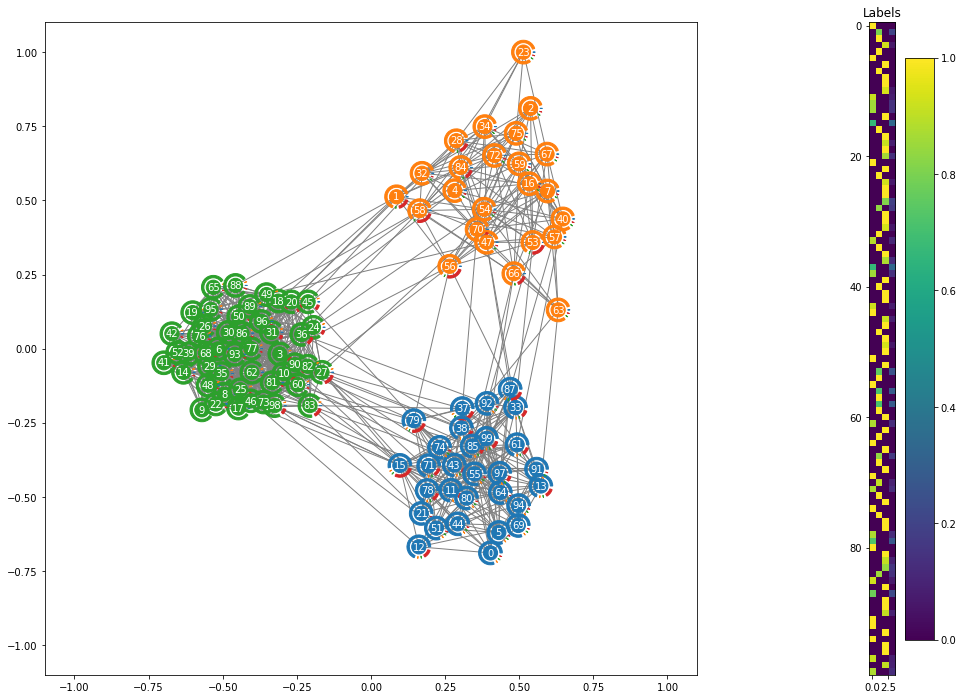

In [9]:
plot_stbm_as_nw2vec(S1)

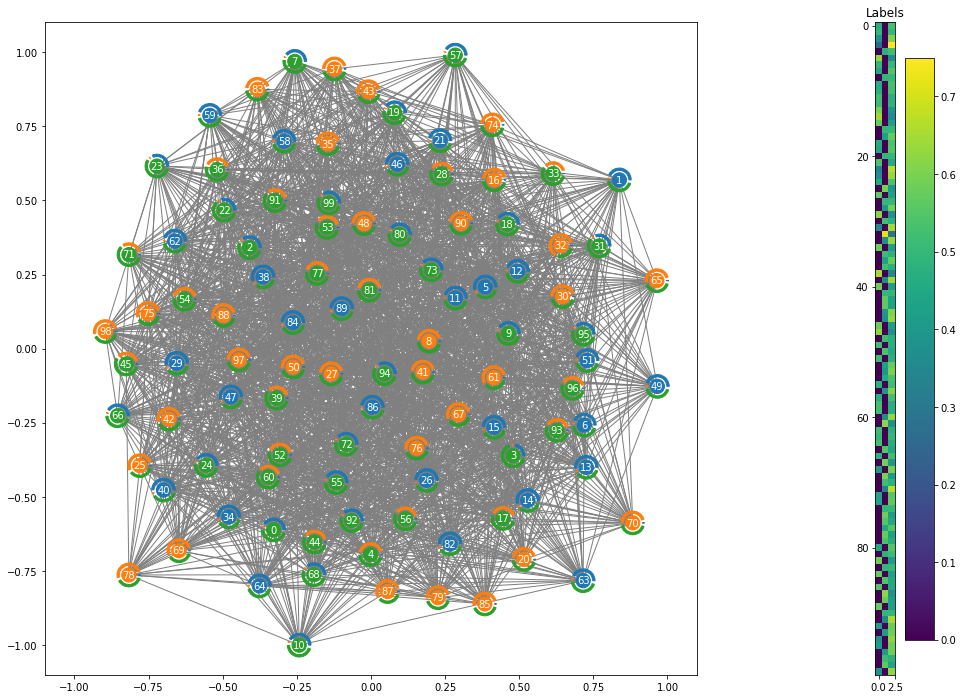

In [10]:
plot_stbm_as_nw2vec(S2)

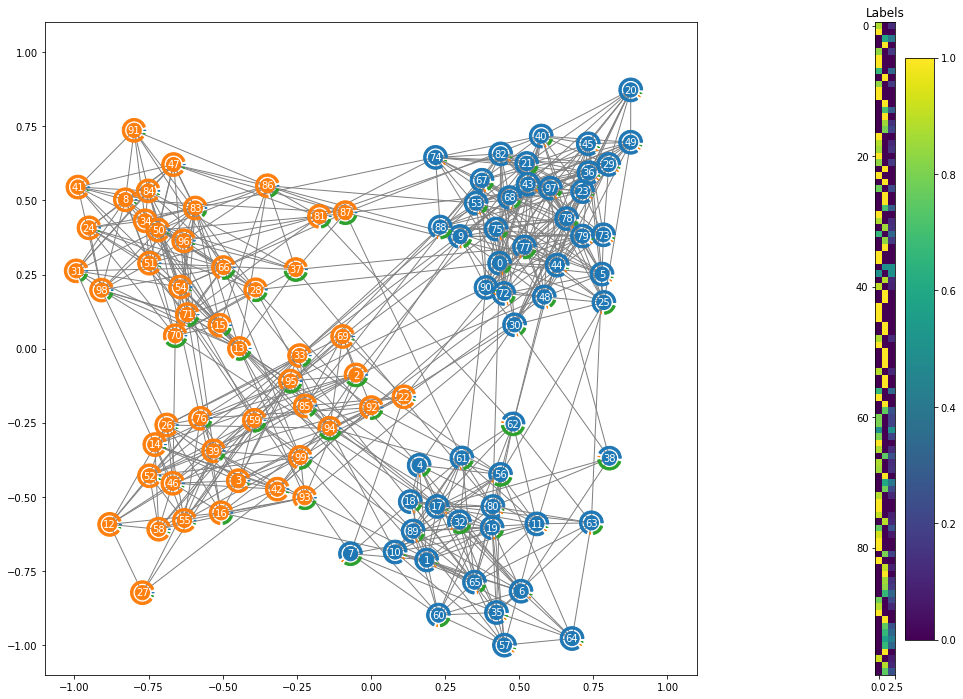

In [11]:
plot_stbm_as_nw2vec(S3)